In [97]:
print("Following is the implememtaion of our model")

Following is the implememtaion of our model


In [98]:
import pandas as pd
import numpy as np
import os
from sklearn import preprocessing
import time
seconds = time.time()
%matplotlib inline

Data Pre-processing

In [99]:


df = pd.read_csv('Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
df.shape

C:\Users\divya\AppData\Local\Temp\ipykernel_20940\943743699.py:1: DtypeWarning: Columns (0,1,3,6,84) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')


(458968, 85)

In [100]:
df.columns = df.columns.str.strip()
df = df.drop(columns=['Fwd Header Length.1'])
df.shape

(458968, 84)

In [101]:
df['Label'].unique()

array(['BENIGN', 'Web Attack   Brute Force', 'Web Attack   XSS',
       'Web Attack   Sql Injection', nan], dtype=object)

In [102]:
df['Label'].value_counts()

Label
BENIGN                        168186
Web Attack   Brute Force        1507
Web Attack   XSS                 652
Web Attack   Sql Injection        21
Name: count, dtype: int64

In [103]:
df = df.drop(df[pd.isnull(df['Flow ID'])].index)
df.shape

(170366, 84)

In [104]:
df.replace('Infinity', -1, inplace=True)
df[["Flow Bytes/s", "Flow Packets/s"]] = df[["Flow Bytes/s", "Flow Packets/s"]].apply(pd.to_numeric)

In [105]:
df.replace([np.inf, -np.inf, np.nan], -1, inplace=True)

In [106]:
string_features = list(df.select_dtypes(include=['object']).columns)
string_features.remove('Label')
string_features

['Flow ID', 'Source IP', 'Destination IP', 'Timestamp']

In [107]:

le = preprocessing.LabelEncoder()
df[string_features] = df[string_features].apply(lambda col: le.fit_transform(col))

Undersampling against unbalance

In [108]:
benign_total = len(df[df['Label'] == "BENIGN"])
benign_total

168186

In [109]:
attack_total = len(df[df['Label'] != "BENIGN"])
attack_total

2180

In [110]:
df.to_csv("web_attacks_unbalanced.csv", index=False)
df['Label'].value_counts()

Label
BENIGN                        168186
Web Attack   Brute Force        1507
Web Attack   XSS                 652
Web Attack   Sql Injection        21
Name: count, dtype: int64

In [111]:
enlargement = 1.1
benign_included_max = attack_total / 30 * 70
benign_inc_probability = (benign_included_max / benign_total) * enlargement
print(benign_included_max, benign_inc_probability)

5086.666666666667 0.03326872232726466


In [112]:
import random
indexes = []
benign_included_count = 0
for index, row in df.iterrows():
    if (row['Label'] != "BENIGN"):
        indexes.append(index)
    else:
        # Copying with benign_inc_probability
        if random.random() > benign_inc_probability: continue
        # Have we achieved 70% (5087 records)?
        if benign_included_count > benign_included_max: continue
        benign_included_count += 1
        indexes.append(index)
df_balanced = df.loc[indexes]
df_balanced['Label'].value_counts()

Label
BENIGN                        5087
Web Attack   Brute Force      1507
Web Attack   XSS               652
Web Attack   Sql Injection      21
Name: count, dtype: int64


Preparing data for training

In [113]:
df_balanced.to_csv("web_attacks_balanced.csv", index=False)
df = pd.read_csv('web_attacks_balanced.csv')


In [114]:
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

In [115]:
excluded = ['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol', 'Timestamp']
df = df.drop(columns=excluded, errors='ignore')

Init_Win_bytes_backward - The total number of bytes sent in initial window in the backward direction
 Init_Win_bytes_forward - The total number of bytes sent in initial window in the forward direction

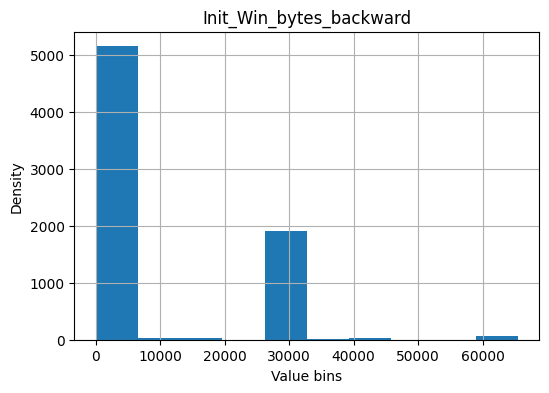

In [116]:
import matplotlib. pyplot as plt
if 'Init_Win_bytes_backward' in df.columns:
    df['Init_Win_bytes_backward'].hist(figsize=(6,4), bins=10);
    plt.title("Init_Win_bytes_backward")
    plt.xlabel("Value bins")
    plt.ylabel("Density")

    plt.savefig('Init_Win_bytes_backward.png', dpi=300)

Train test split

In [117]:
y = df['Label'].values
X = df.drop(columns=['Label'])
print(X.shape, y.shape)

(7267, 76) (7267,)


In [118]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 3551, 1: 1535}

Decision tree classifier

In [119]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(max_leaf_nodes=5, random_state=0)
decision_tree = decision_tree.fit(X_train, y_train)
cross_val_score(decision_tree, X_train, y_train, cv=10)

array([0.96660118, 0.95284872, 0.96267191, 0.95874263, 0.97053045,
       0.95088409, 0.96259843, 0.96062992, 0.95275591, 0.93897638])

In [120]:
from sklearn.tree import export_text
r = export_text(decision_tree, feature_names=X_train.columns.to_list())
print(r)

|--- Init_Win_bytes_backward <= 28952.00
|   |--- Subflow Fwd Bytes <= 33295.00
|   |   |--- Init_Win_bytes_backward <= 233.50
|   |   |   |--- class: 0
|   |   |--- Init_Win_bytes_backward >  233.50
|   |   |   |--- class: 0
|   |--- Subflow Fwd Bytes >  33295.00
|   |   |--- class: 1
|--- Init_Win_bytes_backward >  28952.00
|   |--- Init_Win_bytes_backward <= 29080.00
|   |   |--- class: 1
|   |--- Init_Win_bytes_backward >  29080.00
|   |   |--- class: 0



In [121]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 1536, 1: 645}

Making Prediction

In [122]:
from sklearn.metrics import confusion_matrix
y_pred = decision_tree.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1528,    8],
       [  71,  574]], dtype=int64)

Evaluating Importance

In [123]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(estimator=decision_tree).fit(X_train, y_train)
sfm.estimator_.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.05937675, 0.        , 0.        , 0.        ,
       0.94062325, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     